In [1]:
# generic imports
import scipy.io
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import h5py
from transforms3d.axangles import axangle2mat

sns.set(style="white", context="talk")
%matplotlib inline

Lets explore the dataset

In [2]:
# create the dataset from matlab file
mat = scipy.io.loadmat('dataset-orig/ARS_DLR_DataSet.mat', squeeze_me=True, struct_as_record=True)
print('Number of keys of the dict element', len(mat.keys()))
print()
print('Keys:')
print(mat.keys())

Number of keys of the dict element 59

Keys:
dict_keys(['__header__', '__version__', '__globals__', 'ARS_Maria_Real_Sitting_Heading_2', 'ARS_Maria_Real_Sitting_Heading_3', 'ARS_Maria_Real_Sitting_Heading_4', 'ARS_Maria_FLGUp1', 'ARS_Maria_FLGUp2', 'ARS_Maria_FLGUp3', 'ARS_Maria_FLGUp4', 'ARS_Maria_Jump', 'ARS_Cristina_Test_4_Sensor_Left', 'ARS_Cristina_Test_5_Sensor_Left', 'ARS_Cristina_Test_2_Sensor_Left', 'ARS_Cristina_Test_3_Sensor_Left', 'ARS_Cristina_Test_1_Sensor_Left', 'ARS_Elena_Test_1_Sensor_Right', 'ARS_Elena_Test_2_Sensor_Right', 'ARS_Elena_Test_3_Sensor_Right', 'ARS_Elena_Test_4_Sensor_Right', 'ARS_Elena_Test_5_Sensor_Right', 'ARS_Elena_Walking', 'ARS_Fabian_Test_1_Sensor_Right', 'ARS_Fabian_Test_2_Sensor_Right', 'ARS_Fabian_Test_3_Sensor_Right', 'ARS_Fabian_Test_4_Sensor_Right', 'ARS_Fabian_Test_5_Sensor_Right', 'ARS_Jesus_Test_1_Sensor_Right', 'ARS_Jesus_Test_2_Sensor_Right', 'ARS_Jesus_Test_3_Inverse_Sensor_Right', 'ARS_Jesus_Test_4_Sensor_Right', 'ARS_Jesus_Test_5_Senso

Lets see what a single entry is composed of

In [90]:
example_entry = mat[list(mat.keys())[3]]
example_entry

array([ array([[  4.53400000e+01,  -9.43000200e+00,   1.97339400e+00, ...,
          4.93577200e-01,  -1.54302400e-01,   3.48073800e-01],
       [  4.53500000e+01,  -9.42630400e+00,   1.96610800e+00, ...,
          4.94766900e-01,  -1.55703100e-01,   3.46810900e-01],
       [  4.53600000e+01,  -9.43360500e+00,   1.96788500e+00, ...,
          4.93788400e-01,  -1.54264800e-01,   3.47441300e-01],
       ..., 
       [  5.26090000e+02,  -8.37665400e+00,   4.48864500e+00, ...,
          4.22742800e-01,  -2.76599000e-01,   4.07902500e-01],
       [  5.26100000e+02,  -8.40929300e+00,   4.50478200e+00, ...,
          4.21581900e-01,  -2.75860100e-01,   4.08134000e-01],
       [  5.26110000e+02,  -8.39455000e+00,   4.49753500e+00, ...,
          4.22797100e-01,  -2.75629300e-01,   4.08713200e-01]]),
       array([[  4.53400000e+01,  -2.38955600e-01,   9.77489600e-02, ...,
          8.65125200e-01,   4.73254700e-01,  -1.66097400e-01],
       [  4.53500000e+01,  -2.38969200e-01,   9.78752400e-02

And a single frame recorded by the IMU sensor is like

In [91]:
example_entry[0][0]

array([  4.53400000e+01,  -9.43000200e+00,   1.97339400e+00,
        -1.57358700e+00,  -5.30050200e-02,   4.51815800e-02,
         3.52342500e-02,   4.93577200e-01,  -1.54302400e-01,
         3.48073800e-01])

And the corresponding attitude

In [92]:
example_entry[1][0]

array([ 45.34      ,  -0.2389556 ,   0.09774896,  -0.966098  ,
        -0.4409745 ,   0.8754856 ,   0.1976519 ,   0.8651252 ,
         0.4732547 ,  -0.1660974 ])

According to the dataset documentation, this is what each column represent:

**`example_entry[0]`**

* 1st column is the time extracted from the sensor in seconds. For example: a value 15.6 means that it has passed 15.6 seconds since the sensor started to transmit data.


* 2nd column is the acceleration in the X axis measured by the sensor.
* 3rd column is the acceleration in the Y axis measured by the sensor.
* 4th column is the acceleration in the Z axis measured by the sensor.


* 5th column is the angular velocity in the X axis measured by the sensor.
* 6th column is the angular velocity in the Y axis measured by the sensor.
* 7th column is the angular velocity in the Z axis measured by the sensor.


* 8th column is the magnetic field in the X axis measured by the sensor.
* 9th column is the magnetic field in the Y axis measured by the sensor.
* 10th column is the magnetic field in the Z axis measured by the sensor.

**`example_entry[1]`**

Contains a matrix of double data with the direction cosine matrix extracted from the sensor.

In [93]:
print(example_entry[2])
print(example_entry[3])

['STNDING' 'SITTING' 'STNDING']
[    1  7743  8388 45040 45929 48078]


**`example_entry[2]`**

It contains a cell array where every position is a string. Every string is the identifier of the activity. The possible values of this strings are:
* 'RUNNING' = "running"
* 'WALKING' = "walking"
* 'WALKUPS' = "walking upstairs"
* 'WALKDWS' = "walking downstairs"
* 'STNDING' = "standing"
* 'SITTING' = "sitting"
* 'XLYINGX' = "lying on the floor"
* 'FALLING' = "falling"
* 'JUMPVRT' = "jumping vertically"
* 'JUMPFWD' = "jumping forward"
* 'JUMPBCK' = "jumping backward"
* 'TRANSIT' = "transition between the activities"

As an example, if the cell contains three strings as: "STNDING RUNNING STNDING" means that the person performed these three activities in this 	order.

**`example_entry[3]`**

It is a vector with the index of the rows that indicate the beginning and ending of an activity. The format is the following:

```
	t1_0 t1_f t2_0 t2_f t3_0 t3_f t4_0 t4_f ... tn_0 tn_f

	ti_0 for i=1...n contains the beginning of the activity i.
	ti_f for i=1...n contains the ending of the activity i.
```

Notice that the length of this vector should be twice the length of the cell containing the strings with the activities.

# Configuration file
To store the settings needed to create the output datasets

In [2]:
config = {
    # fill transients with interpolated activities
    # if this is true, remove_transients should be false
    'fill_transients': False,
    'remove_transients': True,
    'adapted_labels_colname': 'adapted_labels',
    'out_filename': 'perot',
    'convert_to_gf': False,
    'normalize_sensor': True,
    'frame_window': 128,
    'frame_stride': 64,
    'augment_sensors': True,
    'augment_factor': 0.35
}

## From matlab to pandas
Lets convert it to a dataframe for later processing.

We have 3 datasets available: `ARS_DLR_DataSet.mat`, `ARS_DLR_DataSet_V2.mat`, `ARS_DLR_Benchmark_Data_Set.mat`.

In [3]:
# initializations
# renaming activities
activity_map = {
    'RUNNING': 'running',
    'WALKING': 'walking',
    'JUMPING': 'jumping',
    'STNDING': 'standing',
    'SITTING': 'sitting',
    'XLYINGX': 'lying',
    'FALLING': 'falling',
    'TRANSUP': 'TRANS-getting up',
    'TRANSDW': 'TRANS-going down',
    'TRNSACC': 'TRANS-accelerating',
    'TRNSDCC': 'TRANS-deccelerating',
    'TRANSIT': 'TRANS-other',
    'WALKUPS': 'walking upstairs',
    'WALKDWS': 'walking downstairs',
    'JUMPVRT': 'jumping vertically',
    'JUMPFWD': 'jumping forward',
    'JUMPBCK': 'jumping backward'
}

data = {
    'person': [],
    'acc_x': [],
    'acc_y': [],
    'acc_z': [],
    'gyr_x': [],
    'gyr_y': [],
    'gyr_z': [],
    'attitude': [],
    'labels': []
}

datasets = ['ARS_DLR_DataSet.mat', 'ARS_DLR_DataSet_V2.mat', 'ARS_DLR_Benchmark_Data_Set.mat']

In [4]:
for dataset in datasets:
    mat = scipy.io.loadmat('dataset-orig/{}'.format(dataset), squeeze_me=True, struct_as_record=True)
    keys = [k for k in mat.keys() if k[0] != '_']
    for j, k in enumerate(keys):
        """
        if j < 11:
            continue
        """
        record = mat[k]
        sensor = record[0]
        attitude = record[1]
        labels = record[2]
        frame_ranges = record[3]
        '''
        print('### DEBUG - {} ###'.format(k))
        print(labels)
        print(frame_ranges)
        '''
        # cycle through the labels
        for i in range(0, len(frame_ranges), 2):
            # create current label
            label_index = math.floor(i/2)
            label = labels[label_index]
            label = activity_map[label]
            # +1 because extremes are included
            frame_length = frame_ranges[i+1] - frame_ranges[i] +1
            data['labels'] += [label] * frame_length

            # manually create labels for transitions
            # if subsequent frame_range is not contiguous, create transition
            if (i+2 < len(frame_ranges)) and (frame_ranges[i+2] > frame_ranges[i+1]+1):
                #print('dentro', frame_ranges[i+2], frame_ranges[i+1]+1)
                frame_length = frame_ranges[i+2] - frame_ranges[i+1] -1
                # labeling transitions with current and subsequent actions
                current_action, next_action = (activity_map[labels[label_index]], activity_map[labels[label_index+1]])
                label = 'TRANS-{}-{}'.format(current_action, next_action)
                data['labels'] += [label] * frame_length
            # this below case represent a mislabling error
            elif (i+2 < len(frame_ranges)) and (frame_ranges[i+2] < frame_ranges[i+1]+1):
                print('mislableing error found, length', frame_ranges[i+1]-frame_ranges[i+2], frame_ranges[i+1])
                frame_ranges[i+2] = frame_ranges[i+1]+1
                """
                frame_length = frame_ranges[i+1] - frame_ranges[i+2] -1
                # labeling transitions with current and subsequent actions
                label = labels[label_index]
                data['labels'] += [label] * frame_length
                """

        # sensor[:, 0] indicates time which is not useful, columns 7: are magnetometer, not useful
        # using list concatenation instead of numpy arrays is more efficient
        data['acc_x'] += sensor[:, 1].tolist()
        data['acc_y'] += sensor[:, 2].tolist()
        data['acc_z'] += sensor[:, 3].tolist()
        data['gyr_x'] += sensor[:, 4].tolist()
        data['gyr_y'] += sensor[:, 5].tolist()
        data['gyr_z'] += sensor[:, 6].tolist()

        data['attitude'] += attitude[:, 1:].tolist()
        data['person'] += [k] * len(sensor[:, 1])

        """
        print(j)
        print(len(data['acc_x']))
        print(len(data['labels']))
        print(labels, len(labels))
        print(frame_ranges, len(frame_ranges))
        if j == 11:
            break
        """
    
df = pd.DataFrame(data = data)

mislableing error found, length 88 21920


In [5]:
df.head()

,acc_x,acc_y,acc_z,attitude,gyr_x,gyr_y,gyr_z,labels,person
0,-9.430002,1.973394,-1.573587,"[-0.2389556, 0.09774896, -0.966098, -0.4409745...",-0.053005,0.045182,0.035234,standing,ARS_Maria_Real_Sitting_Heading_2
1,-9.426304,1.966108,-1.573818,"[-0.2389692, 0.09787524, -0.9660817, -0.440980...",-0.055009,0.052240,0.061471,standing,ARS_Maria_Real_Sitting_Heading_2
2,-9.433605,1.967885,-1.577345,"[-0.2387688, 0.09793719, -0.966125, -0.4408015...",-0.034780,0.030520,0.050830,standing,ARS_Maria_Real_Sitting_Heading_2
3,-9.433682,1.956968,-1.603091,"[-0.2389078, 0.09797277, -0.966087, -0.4408588...",-0.060378,0.067733,0.059497,standing,ARS_Maria_Real_Sitting_Heading_2
4,-9.437164,1.944125,-1.599782,"[-0.2390312, 0.0980841, -0.9660453, -0.4409559...",-0.074121,0.052016,0.067737,standing,ARS_Maria_Real_Sitting_Heading_2


In [6]:
df.shape

(2188965, 9)

Lets see the current labels

In [7]:
activity_counts = df['labels'].value_counts()
#activity_counts.loc[~activity_counts.index.str.startswith('TRANS')]
activity_counts

standing                                       724542
walking                                        369227
sitting                                        353225
lying                                          169309
running                                         90294
walking upstairs                                34574
TRANS-standing-falling                          29139
walking downstairs                              29079
jumping                                         28440
TRANS-getting up                                24153
TRANS-lying-falling                             21466
TRANS-standing-walking upstairs                 21149
TRANS-falling-standing                          20582
TRANS-standing-sitting                          19460
TRANS-walking-standing                          16328
TRANS-walking downstairs-standing               14559
TRANS-TRANS-going down-TRANS-getting up         14360
TRANS-standing-running                          14044
TRANS-standing-jumping forwa

Lets merge together some activities:
* jumping forward, jumping, jumping backward, jumping vertically = jumping
* walking upstairs, walking downstairs, walking = walking

And then for an initial analysis lets *not* consider the transition periods

In [8]:
df['labels'] = df['labels'].where(~df['labels'].isin(['jumping forward', 'jumping backward', 'jumping vertically']), 'jumping')
df['labels'] = df['labels'].where(~df['labels'].isin(['walking upstairs', 'walking downstairs']), 'walking')

In [9]:
# check how many transients there are, before removing them from the dataset
trans_count = df.loc[df['labels'].str.startswith('TRANS')].shape[0]
print('There are {} transition frames, at 100Hz they are approx {}min of data'.format(trans_count, round(trans_count/100/60)))

There are 361319 transition frames, at 100Hz they are approx 60min of data


In [10]:
# remove the transients
if config['remove_transients']:
    df = df.loc[~df['labels'].str.startswith('TRANS')]

In [11]:
# flattens a nested list
def flatten_list(arr):
    return [item for sublist in arr for item in sublist]

# replace transients with action labels
def fill_transients(df, column_name):
    transitions = df['labels'].str.startswith('TRANS')
            #positions = df.index.values
    transitions_index = df.loc[transitions].index

    # create a nested list with groups referred to
    # to each single transition block
    transitions_nested = []
    temp_arr = []
    for i in transitions_index:
        if len(temp_arr) == 0:
            temp_arr.append(i)
            continue
        # if still in the current activity block
        if i == temp_arr[-1]+1:
            temp_arr.append(i)
        else:
            # new activity block found, store current activity block
            transitions_nested.append(temp_arr)
            # and reset temp array with current value
            temp_arr = [i]
    transitions_nested.append(temp_arr)
    
    # just to check everything went right
    transitions_flat = flatten_list(transitions_nested)
    for i, t in enumerate(transitions_index):
        if i >= len(transitions_flat):
            raise ValueError('Out of bound for flattened list at', i)
            break
        if t != transitions_flat[i]:
            raise ValueError('Value {} at position {} was skipped'.format(t, i))
            break
    
    # print(len(flat_list))
    # print(len(transitions_index))
    
    adapted_labels = []
    for trans_block in transitions_nested:
        # get section length
        activity_len = len(trans_block)
        # get previous and following activity
        activity_prev = df.iloc[trans_block[0]-1]['labels']
        activity_foll = df.iloc[trans_block[-1]+1]['labels']
        # half transient associated to prev activity and half to following
        half = math.floor(activity_len/2)
        adapted_labels.extend([activity_prev] * half)
        adapted_labels.extend([activity_foll] * (activity_len-half))
    
    # copy labels column and store 
    df[column_name] = df['labels']
    df[column_name].iloc[transitions_flat] = adapted_labels
    
    return df

label_column_name = 'labels' if not config['fill_transients'] else config['adapted_labels_colname']
if config['fill_transients']:
    df = fill_transients(df, config['adapted_labels_colname'])
    # just to check how many more values have been added to the dataset
    print((df[config['adapted_labels_colname']].value_counts() - df['labels'].value_counts()).sort_values().dropna())

In [12]:
# minutes of each activity
# 100 because it's recorded at 100Hz
round(df[label_column_name].value_counts() / 100 / 60)

standing    121.0
walking      72.0
sitting      59.0
lying        28.0
running      15.0
jumping       8.0
falling       2.0
Name: labels, dtype: float64

In [13]:
# compute the sensor measures in the global frame
def to_global_frame(row):
    attitude = np.array(row['attitude']).reshape(3,3)
    acceleration = np.array([row.acc_x, row.acc_y, row.acc_z])
    gyro = np.array([row.gyr_x, row.gyr_y, row.gyr_z])
    
    # global frame conversions
    acc_gf = np.dot(attitude.T, acceleration)
    gyro_gf = np.dot(attitude.T, gyro)
    
    # replace previous sensor values with new ones on the gf
    row['acc_x'] = acc_gf[0]
    row['acc_y'] = acc_gf[1]
    row['acc_z'] = acc_gf[2]
    
    row['gyr_x'] = gyro_gf[0]
    row['gyr_y'] = gyro_gf[1]
    row['gyr_z'] = gyro_gf[2]
    
    return row

if config['convert_to_gf']:
    df = df.apply(to_global_frame, axis=1)
    df = df.drop('attitude', axis=1)

### Things to test in future
* ~~keep transients~~
* ~~normalizing sensor values~~
* ~~data augmentation of underrepresented classes~~
* test with global frame
* reduce sampling rate to a value lower than 100Hz
* variable frame size?

# Framing

In [14]:
# append zeros if there is space left at the end of the frame
def append_zeros(df, stride, window):
    label = df[label_column_name].iloc[0]
    if df.shape[0] > window:
        n = math.floor((df.shape[0]-window)/stride) + 1
        remain = stride * n - (df.shape[0] - window)
    else:
        remain = window - df.shape[0]
    #print('have to add {} zeros'.format(remain))
    # create the correct nr of zero valued rows and set corresponding label
    df_padded = pd.DataFrame(data = np.zeros((remain, df.shape[1])), columns=df.columns)
    df_padded[label_column_name] = label
    # append zeroed rows on bottom of the dataframe
    return df.append(df_padded)

def framing_range(start, end, stride, window, initialize=False):
    if initialize:
        return 0, start+window
    # updates start and end positions considering stride and window size
    start = end-stride
    end = start+window
    return start, end

In [15]:
window = config['frame_window']
stride = config['frame_stride']
x = []
y = []

# cycle through each unique activity
activities = df[label_column_name].unique()
for activity in activities:
    #print('doing ', activity)
    df_activity = df.loc[df[label_column_name] == activity]
    #print('shape is', df_activity.shape)
    
    # check if padding is needed
    if df_activity.shape[0] % stride != 0:
        df_activity = append_zeros(df_activity, stride, window)
    #print('shape after is', df_activity.shape)
        
    start, end = framing_range(0, 0, stride, window, initialize=True)
    # until current activity is exhausted
    while end != df_activity.shape[0]:
        # get appropriate frame of current activity block
        current = df_activity.iloc[start:end]
        data = np.dstack([
            current['acc_x'],
            current['acc_y'],
            current['acc_z'],
            current['gyr_x'],
            current['gyr_y'],
            current['gyr_z']
            ])
        # using lists for performance
        x += data.tolist()
        y += [activity] * data.shape[0]
        # update start and end window indexes
        start, end = framing_range(start, end, stride, window)

In [16]:
# check if the dimensions are coherent
print(np.array(x).shape)
print(len(y))
assert np.array(x).shape[0] == len(y)

(28545, 128, 6)
28545


# Splitting train and test

In [21]:
x_train, x_test, y_train, y_test = train_test_split(np.array(x), y,
                                                    test_size=0.2,
                                                    random_state=0,
                                                    stratify=y)

In [22]:
print(x_train.shape, len(y_train))
print(x_test.shape, len(y_test))

(22836, 128, 6) 22836
(5709, 128, 6) 5709


Check if train-test splitting was successful and kept classes distribution

In [23]:
ys = {
    'full': pd.Series(y),
    'train': pd.Series(y_train),
    'test': pd.Series(y_test)
}

pd.DataFrame(ys).apply(pd.value_counts).apply(lambda col: col/col.sum())

,full,test,train
standing,0.396532,0.396567,0.396523
walking,0.236889,0.236819,0.236907
sitting,0.193309,0.193204,0.193335
lying,0.092626,0.092661,0.092617
running,0.049361,0.049396,0.049352
jumping,0.024838,0.024873,0.024829
falling,0.006446,0.006481,0.006437


Class proportions are maintained both in test and training

# Training set data augmentation
The goal is to augment each class proportionally to how well its class is represented.

Each class must have a number of samples at least equal to 35% of the most represented class

In [24]:
# some transformation functions

# X must be in form time * features_nr
# es. (3600, 6)

# apply a rotation along a random axis
def DA_Rotation(X):
    X_acc = X[:,:3]
    X_gyr = X[:,3:]
    # axis to apply the rotation to
    axis = np.random.uniform(low=-1, high=1, size=X_acc.shape[1])
    # rotation entity
    angle = np.random.uniform(low=-np.pi, high=np.pi)
    X_acc_rotated = np.matmul(X_acc, axangle2mat(axis,angle))
    X_gyr_rotated = np.matmul(X_gyr , axangle2mat(axis,angle))
    return np.hstack([X_acc_rotated, X_gyr_rotated])

# permute window segments partitions along the time axis
# simply divide the window in n_perm sections and swap
# their places
def DA_Permutation(X, n_perm = 5):
    arr = []
    segment_len = math.floor(X.shape[0]/n_perm)
    for i in range(0, n_perm):
        start = i*segment_len
        end = X.shape[0] if i == n_perm-1 else start+segment_len
        arr += [np.arange(start, end).tolist()]
    arr = np.random.permutation(arr)
    arr = [item for sublist in arr for item in sublist]
    return X[arr, :]

In [25]:
if config['augment_sensors']:
    ys_train = pd.Series(y_train)
    # each class must have at least config.augment_factor % of elements
    # of the most represented class
    lower_bound = int(ys_train.value_counts().max() * config['augment_factor'])
    # number of elements needed for each class to be balanced
    augment_amount = lower_bound - ys_train.value_counts()
    augment_amount = augment_amount[augment_amount>0]
    print('Classes have to be augmented by this number of values')
    print(augment_amount)
    
    # cycle through the index of classes to augment
    augmented_values = []
    labels = []
    # index represent the name of the label/activity
    for activity in augment_amount.index:
        # get indexes corresponding to the current activity
        x_indexes = ys_train[ys_train == activity].index
        # cycle the nr of augmentations to do for this class
        for i in range(0, augment_amount[activity]):
            randint = np.random.randint(0, len(x_indexes))
            current_index = x_indexes[randint]
            # get a random sample from the framed dataset
            window_sample = x_train[current_index]
            
            # apply transformations
            rotate = DA_Rotation(window_sample)
            permute = DA_Permutation(rotate)
            
            # span acc and gyr in depth so to end up with a dimension (?, window_size, 6)
            augmented_values += permute.reshape(1, permute.shape[0], permute.shape[1]).tolist()
            labels.append(activity)

    augmented_values = np.array(augmented_values)
    print('Shape of the augmented sensor values')
    print(augmented_values.shape)
    #print(len(labels))
    
    # attach the augmented data to the training and test datasets
    x_train = np.vstack([x_train, augmented_values])
    y_train.extend(labels)
    
    print('Final shape of the training set and labels')
    print(x_train.shape, len(y_train))
    
    print('Check if the labels are now more balanced')
    print(pd.Series(y_train).value_counts())

Classes have to be augmented by this number of values
lying      1054
running    2042
jumping    2602
falling    3022
dtype: int64
Shape of the augmented sensor values
(8720, 128, 6)
Final shape of the training set and labels
(31556, 128, 6) 31556
Check if the labels are now more balanced
standing    9055
walking     5410
sitting     4415
jumping     3169
running     3169
falling     3169
lying       3169
dtype: int64


## Normalization
Normalization is done both on test and training but using only training set `mean` and `std`

In [26]:
def normalize(x, mean = None, std = None):
    # x is in the form [samplesnr, windowsize, 6]
    x_reshaped = x.reshape(-1, x.shape[-1])
    if mean is None:
        # mean of each column/sensor
        mean = x_reshaped.mean(axis=0)
        std = x_reshaped.std(axis=0)
    x_reshaped = (x_reshaped-mean)/std
    # reshape back to original shape
    return x_reshaped.reshape(x.shape), mean, std

if config['normalize_sensor']:
    x_train, train_mean, train_std = normalize(x_train)
    print(train_mean)
    print(train_std)
    x_test = normalize(x_test, train_mean, train_std)[0]
    for i in np.arange(x_train.shape[-1]):
        print('Train mean of {} is {}, std is {}'.format(i, x_train[:,:,i].mean(), x_train[:,:,i].std()))
        print('Test mean of {} is {}, std is {}'.format(i, x_test[:,:,i].mean(), x_test[:,:,i].std()))
        print()

[ -6.63408026e+00   4.60936859e-01   6.43905775e-01  -2.03518553e-03
  -5.58510494e-04   8.67845878e-03]
[ 6.32075473  4.92475663  5.06105046  0.72654258  0.67187492  0.6213516 ]
Train mean of 0 is 7.532752748628229e-14, std is 0.9999999999999967
Test mean of 0 is -0.2742448304598134, std is 0.6749240529554472

Train mean of 1 is 2.946034987910375e-15, std is 1.000000000000006
Test mean of 1 is 0.036157228661993106, std is 0.6579087442743354

Train mean of 2 is -5.091911456076488e-15, std is 1.000000000000006
Test mean of 2 is 0.008062490756893111, std is 0.69052591623083

Train mean of 3 is 2.6595252528034233e-16, std is 1.0000000000000004
Test mean of 3 is -0.008482853992074638, std is 0.7157812990141973

Train mean of 4 is 1.2905691782640383e-16, std is 1.0000000000000122
Test mean of 4 is 0.011776705406780696, std is 0.6254786094940328

Train mean of 5 is -1.7290995328127073e-15, std is 1.0000000000000016
Test mean of 5 is 0.021801890658761956, std is 0.5693603104671084



# Generate output files

In [27]:
# One hot encoding of the labels
def one_hot_encode(y):
    le = preprocessing.LabelEncoder()
    y_int_encoded = le.fit_transform(y)
    y_int_encoded = np.array(y_int_encoded).reshape(len(y_int_encoded), 1)
    ohe = preprocessing.OneHotEncoder(sparse=False)
    y_ohe = ohe.fit_transform(y_int_encoded)
    return y_ohe
y_train_ohe = one_hot_encode(y_train)
y_test_ohe = one_hot_encode(y_test)

print('y_train with one hot encoding dimension check')
print(y_train_ohe.shape)

y_train with one hot encoding dimension check
(31556, 7)


In [28]:
# saving all the files
with h5py.File('datasets/train-{}.h5'.format(config['out_filename']), 'w') as hf:
    hf.create_dataset("x",  data=x_train)
    hf.create_dataset("y",  data=y_train_ohe)
with h5py.File('datasets/test-{}.h5'.format(config['out_filename']), 'w') as hf:
    hf.create_dataset("x",  data=x_test)
    hf.create_dataset("y",  data=y_test_ohe)

In [29]:
with h5py.File('datasets/train-{}.h5'.format(config['out_filename']), 'r') as hf:
    x = hf['x'][:]
    y = hf['y'][:]
print(y.shape, y_train_ohe.shape)
print(x.shape, x_train.shape)

(31556, 7) (31556, 7)
(31556, 128, 6) (31556, 128, 6)


# Various plots

## Plots generated from framed dataset

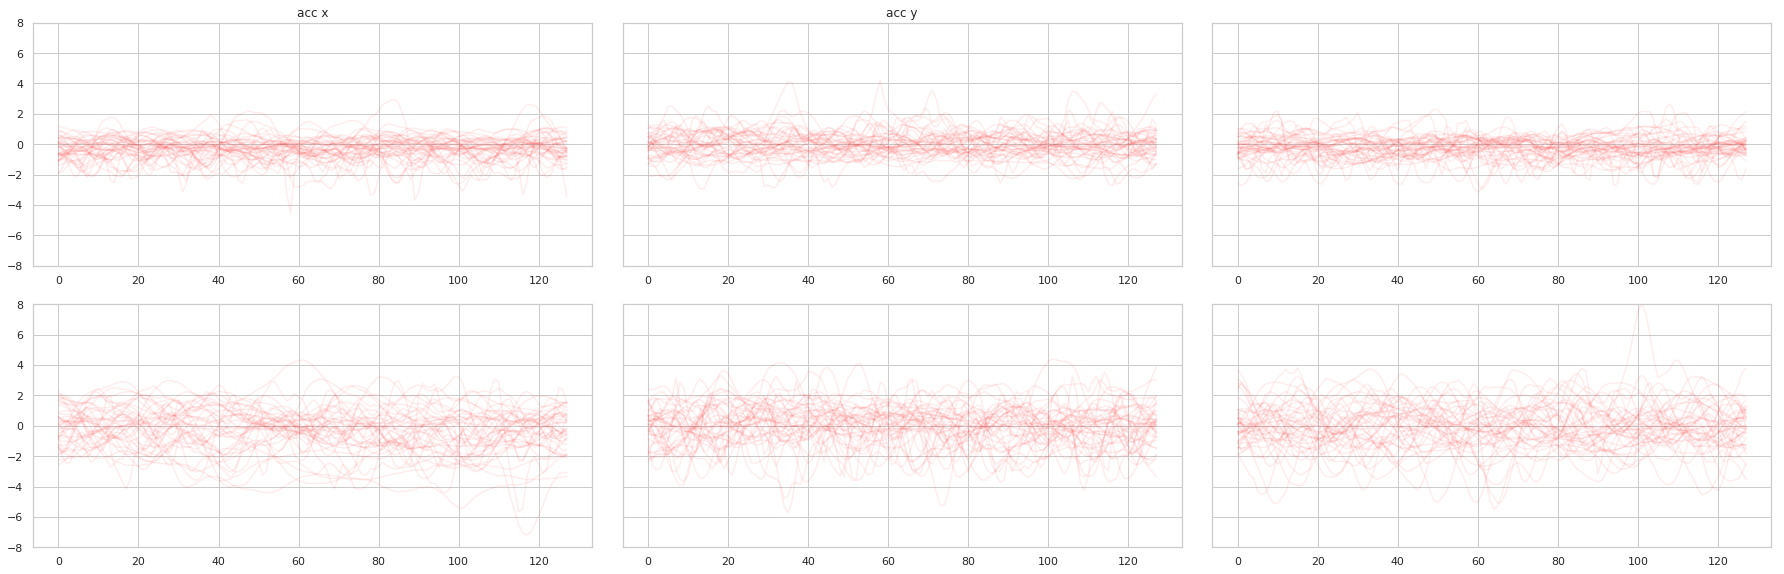

In [145]:
sns.set(style="whitegrid")
ys_train = pd.Series(y_train)
for activity in ['standing']:
    activity_index = ys_train[ys_train == activity].index
    # get a number of random samples of the activity
    random_samples = np.random.choice(jumping, 40, replace=False)
    # sharey='row'
    fig, ax = plt.subplots(2, 3, figsize=(25,8), sharey=True)
    fig.tight_layout()
    ax[0][0].set_ylim([-8,8])
    ax[0][0].set_title('acc x')
    ax[0][1].set_title('acc y')
    
    z = 0
    for r in range(2):
        for c in range(3):
            for i in random_samples:
                y = x_train[i, :, z]
                x = np.arange(len(y))
                sns.lineplot(x, y, color='red', alpha=0.07, ax=ax[r][c])
            z += 1
    fig.savefig('{}.png'.format(activity))

## Plots generated from the dataframe

In [19]:
# normalize acceleration and gyroscope
def normalize_sensors(column):
    return (column-column.mean())/column.std()

dfplot = df.drop('attitude', axis=1)
columns_to_norm = [
    'acc_x', 'acc_y', 'acc_z',
    'gyr_x', 'gyr_y', 'gyr_z']
dfplot[columns_to_norm] = dfplot[columns_to_norm].apply(normalize_sensors)

In [20]:
dfplot['labels'].unique()

array(['standing', 'sitting', 'falling', 'lying', 'jumping', 'walking',
       'running'], dtype=object)

In [21]:
sns.set(style="whitegrid")

/home/damnko/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


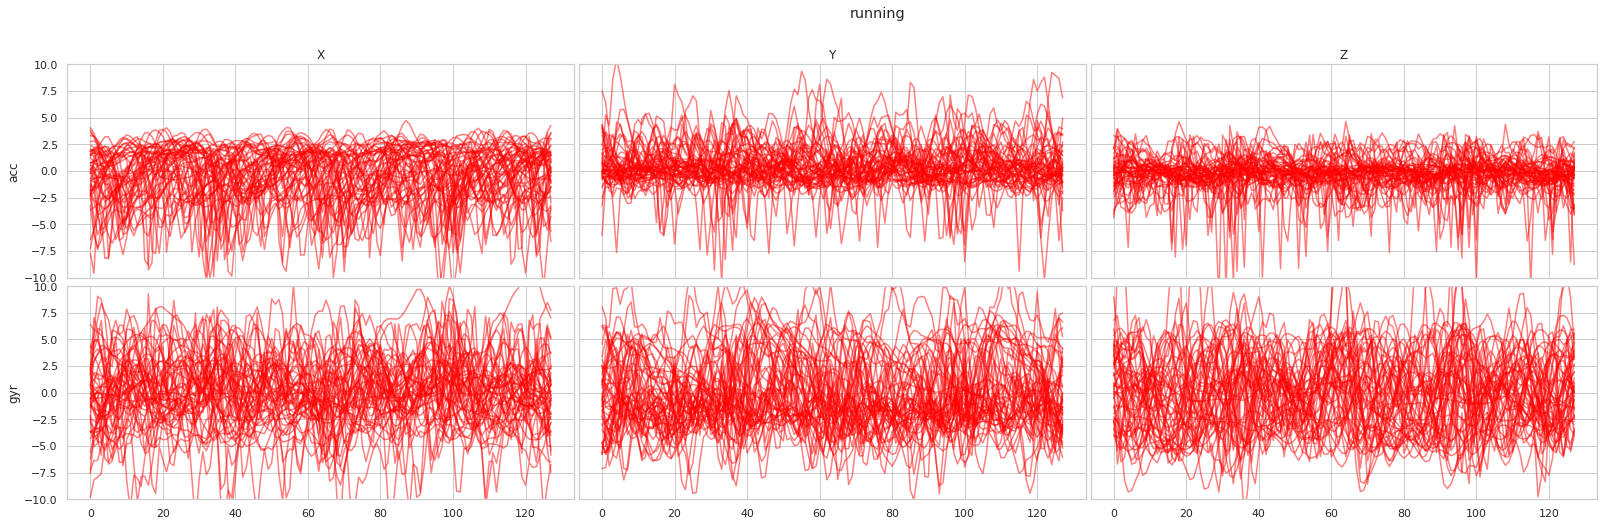

In [42]:
samples = 50
frames = 128
for activity in ['running']:
    dfplot_part = dfplot.loc[df['labels'] == activity].iloc[:samples*frames]
    # sharey='row'
    fig, ax = plt.subplots(2, 3, figsize=(25,8), sharey=True, sharex=True)
    #fig.tight_layout()
    fig.subplots_adjust(wspace=0.01, hspace=0.04)
    # plots setup
    fig.suptitle(activity)
    fig.subplots_adjust(top=0.88, left=0.05)
    ax[0][0].set_ylim([-10,10])
    ax[0][0].set_title('X')
    ax[0][1].set_title('Y')
    ax[0][2].set_title('Z')
    ax[0][0].set_ylabel('acc')
    ax[1][0].set_ylabel('gyr')
    z = 0
    for r in range(2):
        for c in range(3):
            sensor_data = dfplot_part.iloc[:, z].reshape(samples, -1)
            for i in range(samples):
                y = sensor_data[i, :]
                x = np.arange(len(y))
                sns.lineplot(x, y, color='red', alpha=0.5, ax=ax[r][c])
            z += 1
#fig.savefig('{}-df.png'.format(activity))
fig.savefig('{}-df.eps'.format(activity), format='eps', dpi=1000)